In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# source the nxcals python libs
from nxcals.api.extraction.data.builders import *
from datetime import datetime
from datetime import timedelta
import pickle
from matplotlib import gridspec
import seaborn as sns
import pickle

In [4]:
with open('MWPC_RP_run.pickle', 'rb') as f:
    data = pickle.load(f)

with open('Quadrupoles_RP_run.pickle', 'rb') as f:
    df_quadrupoles = pickle.load(f)

In [7]:
selector = "CPS.USER.EAST3"

In [12]:
def gaussian_function(x, a, I, mu, sig):
    return a + I / np.sqrt(2 * np.pi * sig ** 2) * np.exp(-(x - mu) ** 2 / 2. / sig ** 2)

def do_gaussian_fit(x,y):
    mu = np.average(x, weights=np.abs(y - np.min(y)))
    sigma = np.sqrt(np.average(x**2, weights=np.abs(y - np.min(y))) - mu**2)
    p0 = [y.min(), (np.max(y) - np.min(y)) * np.sqrt(2 * np.pi * sigma**2), mu, sigma]
    popt, pcov = curve_fit(gaussian_function, x, y, p0=p0, maxfev=1000) # maxfev is the number of tries it does the fit
    return popt, pcov

def fwhm_func(sigma):
        return abs(2 * np.sqrt(2 * np.log(2)) * sigma)

In [13]:
from scipy.optimize import curve_fit

data.sort_values(by="timestamp", inplace=True)

x = np.linspace(93, -93, num=32)

timestamp_list = []
fwhm_list = []

timestamp_listV = []
fwhm_listV = []

# Vectorized function to fit and calculate FWHM
def process_data(y, selector, timestamp_list, fwhm_list, i):
    try:
        popt, pcov = do_gaussian_fit(x, y)
        perrH = np.sqrt(np.diag(pcov))
        if perrH[3] < 5:
            fwhm = abs(fwhm_func(popt[3]))
            timestamp = data[data.selector == selector].timestamp.iloc[i]
            timestamp_list.append(timestamp)
            fwhm_list.append(fwhm)
    except:
        pass

# Process horizontal data
length = len(data[data.selector == selector])-1
for i in range(length):
    y = data[data.selector == selector].profileHoriz.iloc[i]["elements"][0:32]
    process_data(y, selector, timestamp_list, fwhm_list, i)

# Process vertical data
for i in range(length):
    yV = data[data.selector == selector].profileVert.iloc[i]["elements"][0:32]
    process_data(yV, selector, timestamp_listV, fwhm_listV, i)

Text(0.5, 1.0, 'MWPC beam size during RP measurement')

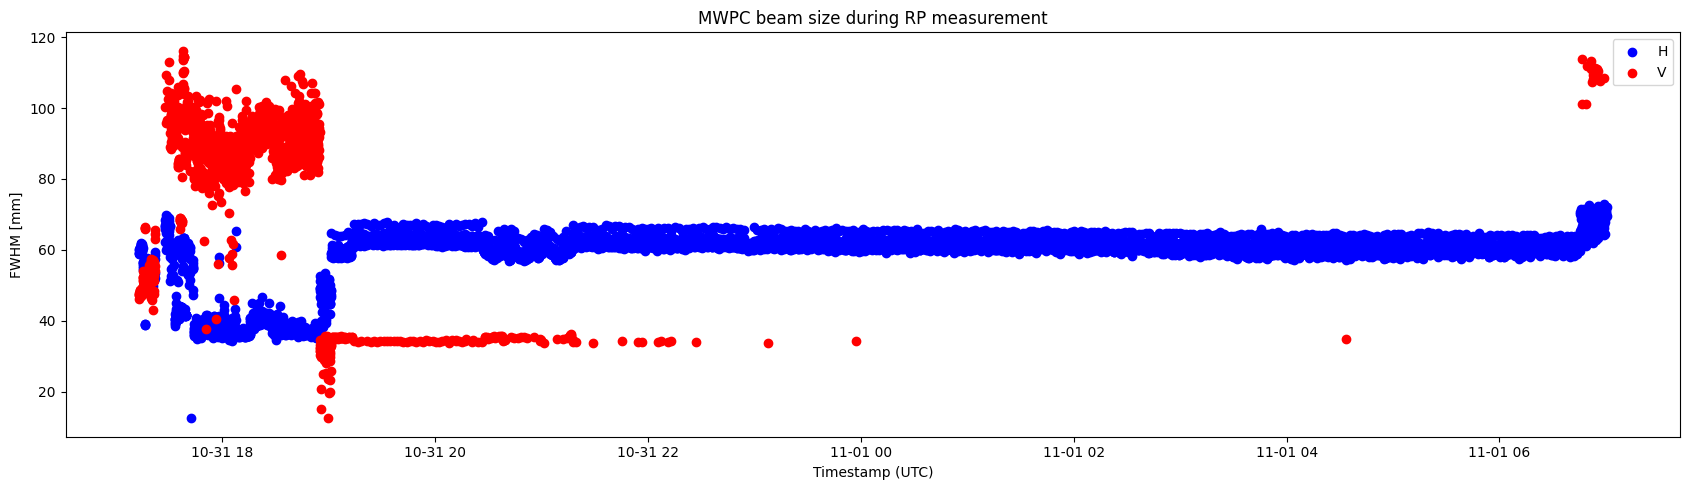

In [14]:
fig, ax = plt.subplots(figsize=(17,5), tight_layout=True)

ax.scatter(timestamp_list, fwhm_list, c="b", label="H")
ax.scatter(timestamp_listV, fwhm_listV, c="r", label="V")

ax.legend()
ax.set_xlabel("Timestamp (UTC)")
ax.set_ylabel("FWHM [mm]")
ax.set_title("MWPC beam size during RP measurement")

# ax.set_xlim(pd.to_datetime('2023-10-31 17:00:00.00'), pd.to_datetime('2023-10-31 19:00:00.00'))

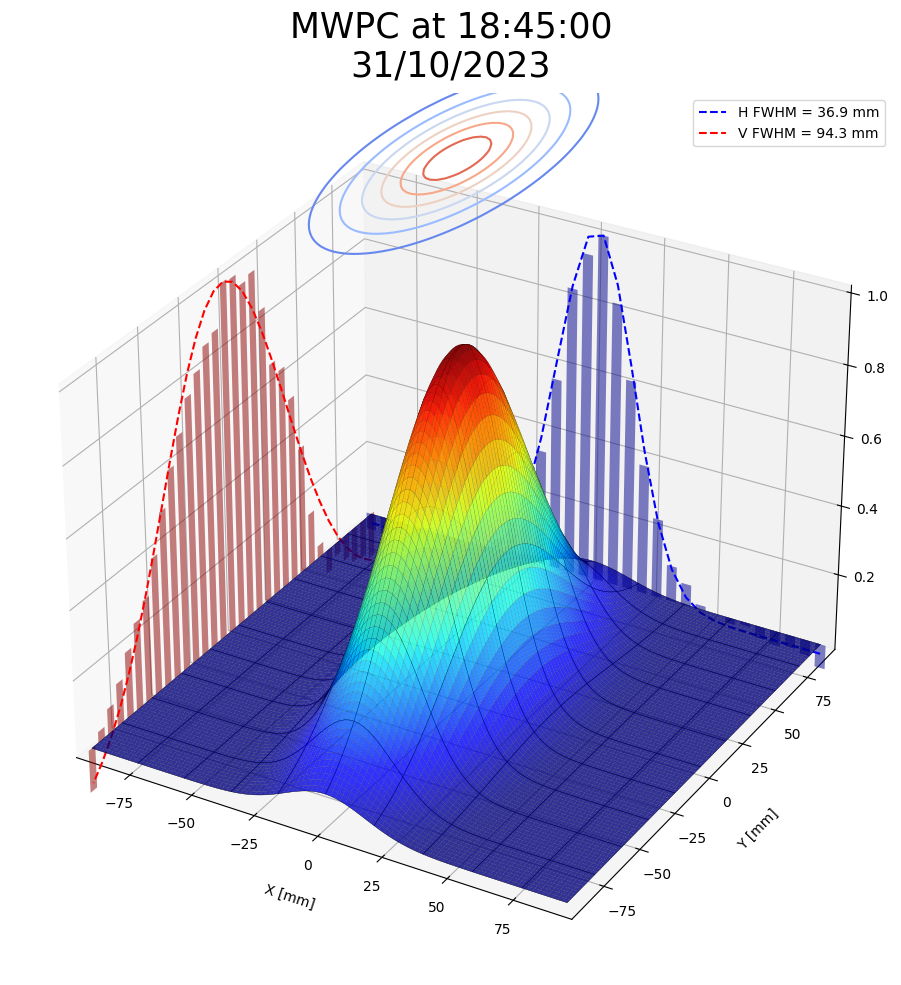

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import multivariate_normal

fig = plt.figure(figsize=(30, 10), tight_layout=True)
ax = fig.add_subplot(projection='3d',computed_zorder=False)

target_timestamp = pd.to_datetime('2023-10-31 18:45:00.00')
differences = (data[data.selector == selector].timestamp - target_timestamp).abs()
closest_index = differences.idxmin()
element = closest_index
MWPC_wire = np.linspace(93, -93, num=32)


data[data.selector == selector].timestamp.loc[element]

# Horizontal Measurement and Gaussian Fit
y = data[data.selector == selector].profileHoriz.loc[element]["elements"][0:32]
ax.bar(MWPC_wire, y/y.max(), zs=MWPC_wire.max(), width=4, zdir='y', color="darkblue", alpha=0.5)

popt, pcov = do_gaussian_fit(MWPC_wire, y)
y_gaussian = gaussian_function(MWPC_wire, popt[0], popt[1], popt[2], popt[3])
ax.plot(xs=MWPC_wire, ys=np.ones(len(MWPC_wire))*MWPC_wire.max(), zs=y_gaussian/y_gaussian.max(), zdir='z', c="b", ls="dashed", label=f"H FWHM = {fwhm_func(popt[3]):.1f} mm")

# Vertical Measurement and Gaussian Fit
y = data[data.selector == selector].profileVert.loc[element]["elements"][0:32]
ax.bar(MWPC_wire, y/y.max(), zs=MWPC_wire.min(), width=4, zdir='x', color="darkred", alpha=0.5)
poptV, pcovV = do_gaussian_fit(MWPC_wire, y)
y_gaussian = gaussian_function(MWPC_wire, poptV[0], poptV[1], poptV[2], poptV[3])
ax.plot(xs=np.ones(len(MWPC_wire))*MWPC_wire.min(), ys=MWPC_wire, zs=y_gaussian/y_gaussian.max(), zdir='z', c="r", ls="dashed", label=f"V FWHM = {fwhm_func(poptV[3]):.1f} mm")


# Set mean and covariance matrix for the multivariate Gaussian
mean = [popt[2], poptV[2]]
covariance_matrix = [[popt[3]**2, 0], [0, poptV[3]**2]]

# Create a grid of points
x = np.linspace(MWPC_wire.min(), MWPC_wire.max(), 100)
y = np.linspace(MWPC_wire.min(), MWPC_wire.max(), 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Create a multivariate Gaussian distribution
mvn = multivariate_normal(mean, covariance_matrix)

# Evaluate the PDF values for each point in the grid
Z = mvn.pdf(pos)
Z=Z/Z.max() # Normalize

# Plot the 3D surface
ax.plot_surface(X, Y, Z, edgecolor='k', lw=0.05, rstride=1, cstride=1, cmap="jet", zorder=99, alpha=0.8)
ax.plot_surface(X, Y, Z, edgecolor='k', lw=0.3, rstride=10, cstride=10, zorder=98, alpha=0.0) # Only the wiring

# Plot projections of the contours for each dimension.
# By choosing offsets that match the appropriate axes limits,
# the projected contours will sit on the 'walls' of the graph.
ax.contour(X, Y, Z, zdir='z', offset=+1.5, cmap='coolwarm')

ax.set(xlim=(x.min(), x.max()), ylim=(y.min(), y.max()), zlim=(Z.min(), Z.max()))

ax.set_xlabel('X [mm]', labelpad=10)
ax.set_ylabel('Y [mm]', labelpad=12)
ax.set_zlabel('Z [arb.]', labelpad=10)

ax.legend(loc='upper right')
ax.dist = 11

fig.suptitle(f"MWPC at {data[data.selector == selector].timestamp.loc[element].strftime('%H:%M:%S')}\n{data[data.selector == selector].timestamp.loc[element].strftime('%d/%m/%Y')}", fontsize=25)
plt.savefig("3d_mwpc.png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')